<a href="https://colab.research.google.com/github/duhlmann/Examplepneumonia-cnn/blob/main/Logistic_Regression_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import os
os.makedirs("/content/data", exist_ok=True)
print("Made /content/data")


# Predicting Canadian Mortgage Rates with Linear Regression

## 1. Introduction
This project explores historical Canadian 5-year conventional mortgage rates (1951–2024).  
Goal: predict mortgage rates using simple linear regression.  
I show the importance of **feature engineering** by starting with calendar-based features, then adding a lag feature.



## 2. Data Source
Dataset: [Conventional Mortgage Lending Rates](https://www.kaggle.com/datasets/noeyislearning/conventional-mortgage-lending-rates) (Kaggle).  
It contains monthly mortgage rates from 1951 to 2024.

In [23]:
import os
print(os.path.exists("/root/.kaggle/kaggle.json"))

True


In [25]:
!kaggle datasets download -d noeyislearning/conventional-mortgage-lending-rates -p /content/data

Dataset URL: https://www.kaggle.com/datasets/noeyislearning/conventional-mortgage-lending-rates
License(s): CC0-1.0
conventional-mortgage-lending-rates.zip: Skipping, found more recently modified local copy (use --force to force download)


In [28]:
!unzip -o /content/data/conventional-mortgage-lending-rates.zip -d /content/data

Archive:  /content/data/conventional-mortgage-lending-rates.zip
  inflating: /content/data/mortgage_lending_rates.csv  


In [29]:
import pandas as pd

df = pd.read_csv("/content/data/mortgage_lending_rates.csv")
df.head()

,REF_DATE,GEO,DGUID,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,1951-01,Canada,2016A000011124,Percent,239,units,0,v733833,1,5.00,NaN,NaN,NaN,2
1,1951-02,Canada,2016A000011124,Percent,239,units,0,v733833,1,5.00,NaN,NaN,NaN,2
2,1951-03,Canada,2016A000011124,Percent,239,units,0,v733833,1,5.00,NaN,NaN,NaN,2
3,1951-04,Canada,2016A000011124,Percent,239,units,0,v733833,1,5.25,NaN,NaN,NaN,2
4,1951-05,Canada,2016A000011124,Percent,239,units,0,v733833,1,5.50,NaN,NaN,NaN,2


## 3. Data Preparation
- Loaded CSV from Kaggle into Colab.  
- Extracted `Year` and `Month` from the date column.  
- Added a **lag feature** (`PrevRate`) = previous month’s rate.  

In [30]:
# Add previous month's rate (lag feature)
df["PrevRate"] = df["VALUE"].shift(1)

# Drop only the rows where PrevRate is NaN (the very first row)
df = df.dropna(subset=["PrevRate"])

df[["REF_DATE", "VALUE", "PrevRate"]].head(10)

,REF_DATE,VALUE,PrevRate
1,1951-02,5.00,5.00
2,1951-03,5.00,5.00
3,1951-04,5.25,5.00
4,1951-05,5.50,5.25
5,1951-06,5.50,5.50
6,1951-07,5.62,5.50
7,1951-08,5.62,5.62
8,1951-09,5.75,5.62
9,1951-10,5.75,5.75
10,1951-11,5.75,5.75


In [32]:
# Extract Year and Month from REF_DATE
df["Year"] = df["REF_DATE"].str.split("-").str[0].astype(int)
df["Month"] = df["REF_DATE"].str.split("-").str[1].astype(int)

# Add lag feature: previous month's rate
df["PrevRate"] = df["VALUE"].shift(1)

# Drop only the first row (where PrevRate is NaN)
df = df.dropna(subset=["PrevRate"])

# Quick check
df[["REF_DATE", "VALUE", "PrevRate"]].head()

,REF_DATE,VALUE,PrevRate
2,1951-03,5.00,5.00
3,1951-04,5.25,5.00
4,1951-05,5.50,5.25
5,1951-06,5.50,5.50
6,1951-07,5.62,5.50


# 4. Modeling
- **Model 1:** Linear Regression with `Year` and `Month`.  
  - Performed poorly (R² ≈ 0.08).  
- **Model 2:** Linear Regression with `Year`, `Month`, and `PrevRate`.  
  - Performance improved dramatically. Predictions closely followed actual rates.  


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Features and target
X = df[["Year", "Month", "PrevRate"]]
y = df["VALUE"]

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# Predict
y_pred = lin_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"MAE:  {mae:.3f}")
print(f"R²:   {r2:.3f}")

RMSE: 0.310
MAE:  0.153
R²:   0.990


## 5. Results
- Scatter plot shows actual vs predicted rates.  
- Adding the lag feature reduced error and improved R² significantly.  


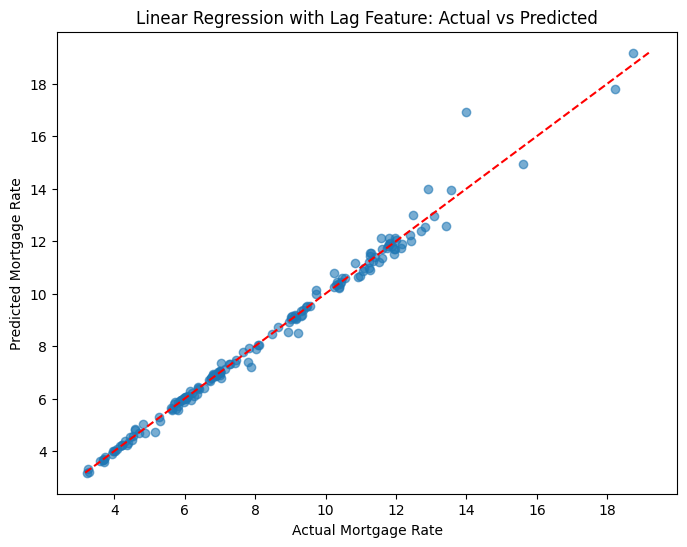

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Mortgage Rate")
plt.ylabel("Predicted Mortgage Rate")
plt.title("Linear Regression with Lag Feature: Actual vs Predicted")

# Add diagonal reference line
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.show()


## 6. Conclusion
- Time-series data needs **temporal features** to capture patterns.  
- Lag features are a simple but powerful way to improve regression models.  
- Next steps: explore more lags (e.g., 12 months), rolling averages, or advanced time-series models (ARIMA, Prophet).
